In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy import misc, ndimage
import glob
import matplotlib.image as mpimg
import cv2

#from transform_image_data import centre_crop

%matplotlib inline

In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
print(tf.__version__)

Default GPU Device:/device:GPU:0
2.1.0


In [3]:
#import Data

train_folder = "C:/Users/Hameez/.conda/envs/gemstone_dataset/Data/Cropped/Train/"
test_folder = "C:/Users/Hameez/.conda/envs/gemstone_dataset/Data/Cropped/Test/"


# img = image.load_img(train_folder+"/Alexandrite/alexandrite_2.jpg")
# # plt.imshow(img)
# # plt.show()
# print(cv2.imread("Data/Train/Alexandrite/alexandrite_24.jpg").shape)

#------------Image augmentation for train images----------------------------------#
train = ImageDataGenerator(rescale=1/255, shear_range=0.5,
                                  rotation_range=90, channel_shift_range=2.5)
#---------------------------------------------------------------------------#

test = ImageDataGenerator(rescale=1/255)

im_height = im_width = 299

batch_sz = 32

train_data = train.flow_from_directory(train_folder,
                                       target_size=(im_height,im_width),
                                       class_mode='categorical', batch_size=batch_sz)
test_data = test.flow_from_directory(test_folder,
                                       target_size=(im_height,im_width),
                                       class_mode='categorical')





Found 2857 images belonging to 87 classes.
Found 363 images belonging to 87 classes.


In [ ]:
# images = []
# stone = 'Ametrine'
# for img_path in glob.glob(train_folder+stone+'/*.jpg'):
#     images.append(mpimg.imread(img_path))

# plt.figure(figsize=(25,25))
# columns = 4
# for i, image in enumerate(images):
#     if i > 7:
#         break
#     else:
#         plt.subplot(len(images) / columns + 1, columns, i + 1)
#         plt.title(stone)
#         plt.imshow(image)
        

In [ ]:
# test_augment = ImageDataGenerator(rescale=1/255, zoom_range=2.0, shear_range=0.5,
#                                   rotation_range=60, channel_shift_range=2.5)#, ,)
# img = image.load_img(train_folder+"/Chalcedony/chalcedony_5.jpg")
# plt.imshow(img)



In [ ]:

# x = img_to_array(x)

# x = x.reshape((1,) + x.shape)
# # x.shape

# i = 0
# for batch in test_augment.flow(x, batch_size=1,
#                               save_to_dir='Augmented', save_prefix='alexandrite',
#                                save_format='jpeg',):
#     i += 1
#     if i > 20:
#         break

### CNN Model 

In [ ]:

# cnn_model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(im_height,im_width,3)),
#                                         tf.keras.layers.MaxPool2D(2,2),
#                                         #
#                                         tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
#                                         tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
#                                         tf.keras.layers.MaxPool2D(2,2),
                                        
#                                         tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
#                                         tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
#                                         tf.keras.layers.MaxPool2D(2,2),
                                        
#                                         tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
#                                         tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
#                                         tf.keras.layers.MaxPool2D(2,2),
#                                         #
#                                         tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
#                                         tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
#                                         tf.keras.layers.MaxPool2D(2,2),
#                                         #
#                                         tf.keras.layers.Flatten(),
#                                         #
#                                         tf.keras.layers.Dense(512, activation='relu'),
#                                         #
#                                         tf.keras.layers.Dense(1024, activation='relu'),
#                                         #
#                                         tf.keras.layers.Dense(87, activation='softmax')
#                                         ])
# cnn_model.summary()


In [4]:
base_model = keras.applications.InceptionV3(weights='imagenet', include_top=False)
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [5]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
predictions =  tf.keras.layers.Dense(87, activation='softmax')(x)

for layers in base_model.layers:
    layers.trainable = False # freeze layers that we dont want to train
    

final_model = tf.keras.models.Model(inputs=base_model.inputs, outputs=predictions)
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
final_model.compile(loss='categorical_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])

history = final_model.fit_generator(train_data, epochs=20, validation_data=test_data, verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 90 steps, validate for 12 steps
Epoch 1/20
90/90 [==============================] - 292s 3s/step - loss: 3.1022 - accuracy: 0.2783 - val_loss: 5.7945 - val_accuracy: 0.0964
Epoch 2/20
90/90 [==============================] - 365s 4s/step - loss: 2.0120 - accuracy: 0.4813 - val_loss: 5.6675 - val_accuracy: 0.1322
Epoch 3/20
90/90 [==============================] - 357s 4s/step - loss: 1.6747 - accuracy: 0.5450 - val_loss: 5.1891 - val_accuracy: 0.1625
Epoch 4/20
90/90 [==============================] - 373s 4s/step - loss: 1.4896 - accuracy: 0.5856 - val_loss: 7.8734 - val_accuracy: 0.1295
Epoch 5/20
90/90 [==============================] - 367s 4s/step - loss: 1.4154 - accuracy: 0.6097 - val_loss: 7.4006 - val_accuracy: 0.1157
Epoch 6/20
90/90 [==============================] - 373s 4s/step - loss: 1.2521 - accuracy: 0.6538 - val_loss: 6.0157 - val_acc

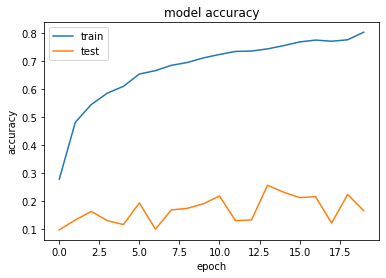

In [7]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

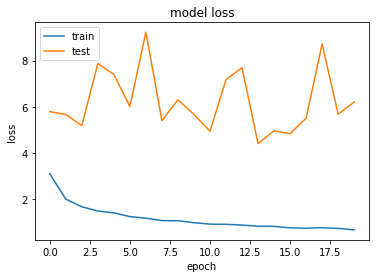

In [8]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:

# model_path ='Saved Models/gs_mcl_tl_v3.0.h5'
# cnn_model.save(model_path)

# model = tf.keras.models.load_model(model_path)

In [ ]:
unsean_stone_path = "C:/Users/Hameez/.conda/envs/gemstone_dataset/Data/Unseen/citrine.jpg"
img = image.load_img(unsean_stone_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print(os.path.basename(unsean_stone_path))
img

In [ ]:
preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

In [ ]:
model.summary()

rutilated-quartz-zoom.jpg


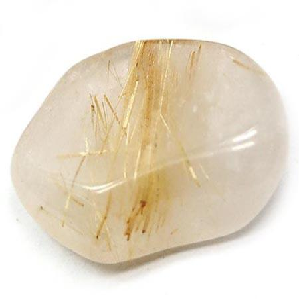

ERROR! Session/line number was not unique in database. History logging moved to new session 939


In [12]:
shape = (im_height,im_width)
unsean_stone_path = "C:/Users/Hameez/.conda/envs/gemstone_dataset/Data/Unseen/rutilated-quartz-zoom.jpg"
    
# #img = cv2.imread(os.path.join(unsean_stones_folder)
img = image.load_img(unsean_stone_path, target_size=shape)
#new_img = centre_crop(img, 25)
img_arr = image.img_to_array(img)
print(os.path.basename(unsean_stone_path))
img

In [ ]:
img_arr = np.expand_dims(img_arr, axis=0)
predict = final_model.predict(img_arr)
classess = train_data.class_indices
for name in classess:
    if classess[name] == int(predict):
        print("Predicts that its a: "+name)
    else:
        "Couldn't find stone name!"


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



ERROR! Session/line number was not unique in database. History logging moved to new session 940
Traceback (most recent call last):
  File "C:\Users\Hameez\.conda\envs\gpu_tf\lib\site-packages\IPython\core\interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cfed203a8a8a>", line 5, in <module>
    if classess[name] == int(predict):
TypeError: only size-1 arrays can be converted to Python scalars

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Hameez\.conda\envs\gpu_tf\lib\site-packages\IPython\core\interactiveshell.py", line 2045, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Hameez\.conda\envs\gpu_tf\lib\site-packages\IPython\core\ultratb.py",